Consider a sky-diver falling towards the surface of Earth. The diver brought with them a temperature sensor that took multiple measurements along the descent. The diver is interested in determining their terminal velocity given these measurements.

Problem: Given a temperature measurement, can one estimate the velocity as a function of time?

In [1]:
using LinearAlgebra: diagm
using Random
using CairoMakie
using ForwardDiff

CairoMakie.activate!()

include("kalmanflt.jl");
include("extendedkalmanflt.jl");

The system is a particle falling due to gravity WITH air resistance. For this simulation, the falling object will acheive terminal velocity. The velocity as a function of time is modeled as

$$
\begin{align}
v(t) &= v_{\infty} \tanh\left(\frac{g t}{v_{\infty}}\right)
\end{align}
$$

where $v_{\infty}$ is the terminal velocity as time approaches infinity and $g$ is the acceleration due to gravity. 

What we need now is a mapping between temperature and altitude.
I will use the data from https://www.engineeringtoolbox.com/air-altitude-temperature-d_461.html and linearize the temperature model. For the terminal velocity, I make-up a weak, linear relationship between temperature and terminal velocity.

$$
\begin{align}
h_{n} &= h_{n}(t) = h_{n-1} + v_{n-1} \Delta t \\
v_{n} &= v_{n}(t,\Delta t) = v_{n-1} + \frac{\partial}{\partial t}\left[v_{\infty}\tanh\left(\frac{g t}{v_{\infty}}\right)\right] \Delta t = v_{n-1} +  g \Delta t \text{sech}^2\left(\frac{g t}{v_{\infty}}\right)\\
v_{\infty} &\rightarrow v_{\infty}(T) = m_v T + b_v \\
T &\rightarrow T(h) = m_T h + b_T
\end{align}
$$

In [2]:
time_steps = 150

par_values_dict = Dict(
    "time_delta_s"=>0.1,
    "VInfS_m__Ks"=>-0.1481,
    "VInfI_m__s"=>94.44,
    "TS_K__m"=>-0.006_835,
    "TI_K"=>288.706,
    "accel_m__s2"=>-9.8,
)

@enum StateIndex begin
    ALT=1 
    VEL=2 
    TIM=3
end
length_state_vector = length(instances(StateIndex))

@enum MeasurementIndex begin
    TEMP=1
end
length_measurement_vector = length(instances(MeasurementIndex));

In [3]:
FloatOrDual = Union{Float64, ForwardDiff.Dual}

@inline function linear_fcn(
        m::FloatOrDual, 
        b::FloatOrDual, 
        x::FloatOrDual
)::FloatOrDual
    return m * x + b
end;

In [4]:
function time_step_s(
        time_delta_s::FloatOrDual, 
        current_time_s::FloatOrDual
)::FloatOrDual
    return time_delta_s + current_time_s
end


function time_step_s(
        time_delta_s::FloatOrDual, 
        state::Vector
)::FloatOrDual
    return time_step_s(time_delta_s, state[Int(TIM)])
end;

In [39]:
function fTemperature_K(
        TS_K__m::FloatOrDual, 
        TI_K::FloatOrDual, 
        altitude_m::FloatOrDual
)::FloatOrDual
    return linear_fcn(TS_K__m, TI_K, altitude_m)
end


function fTemperature_K(
        TS_K__m::FloatOrDual, 
        TI_K::FloatOrDual, 
        state::Vector
)::FloatOrDual
    return fTemperature_K(TS_K__m, TI_K, state[Int(ALT)])
end;


function measurement_function_temperature_K(
        state::Vector
)::FloatOrDual
    return fTemperature_K(
        par_values_dict["TS_K__m"], 
        par_values_dict["TI_K"], 
        state
    )
end;


measurement_function! = (vector_fcn::Vector, state::Vector) -> 
begin
    vector_fcn[Int(TEMP)] = measurement_function_temperature_K(state)
    return nothing
end

measurement_function = state -> (
    vector_fcn = fill(zero(promote_type(eltype(state), Float64)), length_measurement_vector); 
    measurement_function!(vector_fcn, state); 
    return vector_fcn
);

In [8]:
function fVInf_m__s(
        VInfS_m__Ks::FloatOrDual, 
        VInfI_m__s::FloatOrDual, 
        T_K::FloatOrDual
)::FloatOrDual
    return linear_fcn(VInfS_m__Ks, VInfI_m__s, T_K)
end


function fVInf_m__s(
        VInfS_m__Ks::FloatOrDual, 
        VInfI_m__s::FloatOrDual, 
        TS_K__m::FloatOrDual, 
        TI_K::FloatOrDual, 
        state::Vector
)::FloatOrDual
    return fVInf_m__s(VInfS_m__Ks, VInfI_m__s, fTemperature_K(TS_K__m, TI_K, state))
end;

In [9]:
function hn_m(
        time_delta_s::FloatOrDual, 
        hnm1_m::FloatOrDual, 
        vnm1_m__s::FloatOrDual
)::FloatOrDual
    return linear_fcn(time_delta_s, hnm1_m, vnm1_m__s)
end


function hn_m(
        time_delta_s::FloatOrDual, 
        state::Vector
)::FloatOrDual
    return hn_m(time_delta_s, state[Int(ALT)], state[Int(VEL)])
end;

In [10]:
function vn_m__s( 
    time_delta_s::FloatOrDual, 
    t_s::FloatOrDual,
    VInf_m__s::FloatOrDual,
    accel_m__s2::FloatOrDual,
    vmn1_m__s::FloatOrDual
)::FloatOrDual
    return (
        vmn1_m__s 
        + time_delta_s 
        * accel_m__s2 * sech(accel_m__s2 * t_s / VInf_m__s)^2
    )
end


function vn_m__s( 
    time_delta_s::FloatOrDual, 
    VInfS_m__Ks::FloatOrDual, 
    VInfI_m__s::FloatOrDual, 
    TS_K__m::FloatOrDual, 
    TI_K::FloatOrDual, 
    accel_m__s2::FloatOrDual,
    state::Vector,
)::FloatOrDual
    return vn_m__s(
        time_delta_s,
        state[Int(TIM)],
        fVInf_m__s(VInfS_m__Ks, VInfI_m__s, TS_K__m, TI_K, state),
        accel_m__s2,
        state[Int(VEL)]
    )
end;

In [11]:
state_function_altitude_m(state::Vector) = hn_m(
    par_values_dict["time_delta_s"], 
    state
);


state_function_velocity_m__s(state::Vector) = vn_m__s(
    par_values_dict["time_delta_s"], 
    par_values_dict["VInfS_m__Ks"],
    par_values_dict["VInfI_m__s"],
    par_values_dict["TS_K__m"],
    par_values_dict["TI_K"],
    par_values_dict["accel_m__s2"],
    state
);


state_function_time_s(state::Vector) = time_step_s(
    par_values_dict["time_delta_s"], 
    state
);


state_function! = (vector_fcn::Vector, state::Vector) -> 
begin
    vector_fcn[Int(ALT)] = state_function_altitude_m(state)
    vector_fcn[Int(VEL)] = state_function_velocity_m__s(state)
    vector_fcn[Int(TIM)] = state_function_time_s(state)
    return nothing
end

state_function = state -> (
    vector_fcn = fill(zero(promote_type(eltype(state), Float64)), length_state_vector); 
    state_function!(vector_fcn, state); 
    return vector_fcn
);

In [43]:
"""Temperature variations"""
artificial_noise_K = 0.1  # Kelvin
observation_cov = diagm([1.0^2])  # Kelvin^2

system_noise_cov = diagm([100.0^2, 1.00^2, 0.00]);

In [44]:
true_state_fcn_time = Array{Vector{Float64}}(undef, time_steps)
measurements_array = Array{Vector{Float64}}(undef, time_steps)
states_fcn_time = Array{KalmanState{Float64}}(undef, time_steps);

In [45]:
"""Define a system where a falling object is thought to be released at rest 
at 3 km above the Earth's surface with wind resistence.
"""
true_state_vector = Vector{Float64}([2915.000, 0.0, 0.0])
initial_state_vector = Vector{Float64}([3000.0, 1.2, 0.0])
initial_state_cov = [1000.0^2 10.0   0.0; 
                       10.0    1.0^2 0.0;
                        0.0     0.0  0.1]
initial_state = KalmanState{Float64}(initial_state_vector, initial_state_cov)
curr_state = KalmanState{Float64}(initial_state.state, initial_state.cov)

for step in 1:time_steps
    
#     println("step=$step")
    curr_step_time_s = (step) * par_values_dict["time_delta_s"]
    
    # Set the true parameters for this time step
    true_state_vector = state_function(true_state_vector)
    true_state_fcn_time[step] = true_state_vector
#     println("true_state_vector=$(true_state_vector)")
    
    # Predict the next state and save those predictions into the parameter dictionary
    pred_state::KalmanState = predict_state(
        state_function, curr_state, system_noise_cov
    )
#     println("pred_state=$(pred_state)")
    
    meas_vec = measurement_function(true_state_vector)
    meas_vec[Int(TEMP)] += artificial_noise_K * randn()
#     println("meas_vec=$(meas_vec)")
    measurements_array[step] = meas_vec
    
    # Get the corrected current state
    curr_state = correct_state(
        measurement_function,
        pred_state,
        KalmanObservation{Float64}(meas_vec, observation_cov)
    )
#     println("curr_state=$(curr_state)")
    states_fcn_time[step] = curr_state
    
end

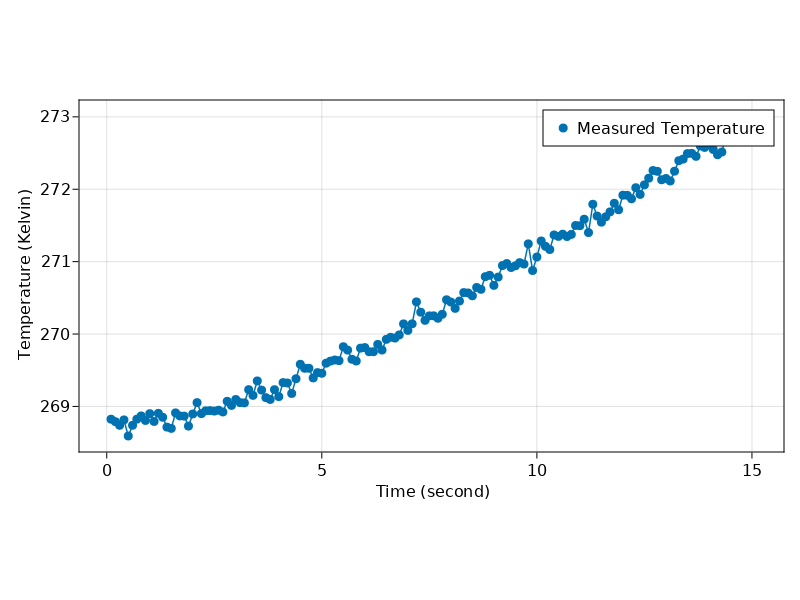

In [46]:
time_axis_s = [(step * par_values_dict["time_delta_s"]) for step in 1:time_steps]
scatter(
    time_axis_s,
    [measurements_array[step][1] for step in 1:time_steps],
    axis = (aspect = 2, xlabel = "Time (second)", ylabel = "Temperature (Kelvin)"),
    label="Measured Temperature"
)
lines!(
    time_axis_s, 
    [measurements_array[step][1] for step in 1:time_steps]
)
axislegend()
current_figure()

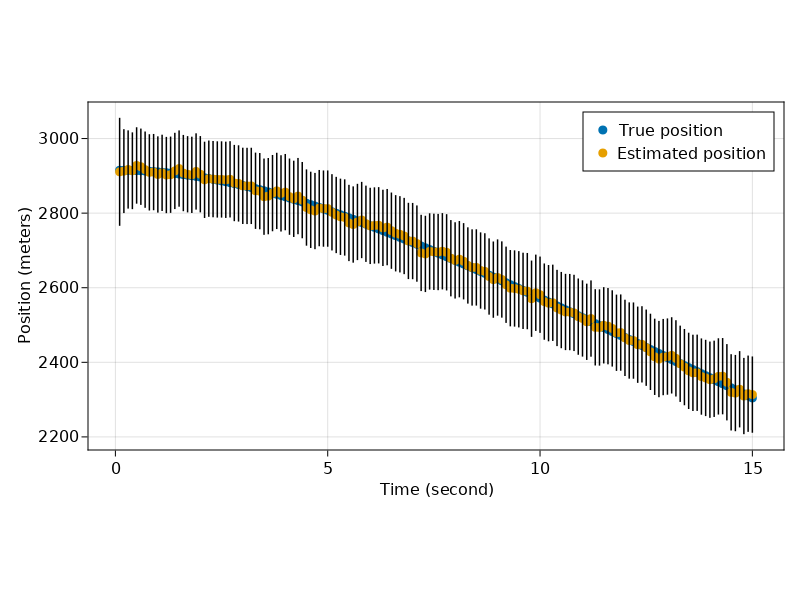

In [47]:
true_positions_m = [tr_st[1] for tr_st in true_state_fcn_time]
esti_positions_m = [s.state[1] for s in states_fcn_time]

scatter(
    time_axis_s,
    true_positions_m,
    axis = (aspect = 2, xlabel = "Time (second)", ylabel = "Position (meters)"),
    label="True position"
)

lines!(
    time_axis_s, 
    true_positions_m
)

scatter!(
    time_axis_s,
    esti_positions_m,
    label="Estimated position"
)

lines!(
    time_axis_s, 
    esti_positions_m
)

errorbars!(
    time_axis_s,
    esti_positions_m,
    [sqrt(s.cov[1, 1]) for s in states_fcn_time]
)


axislegend()
current_figure()

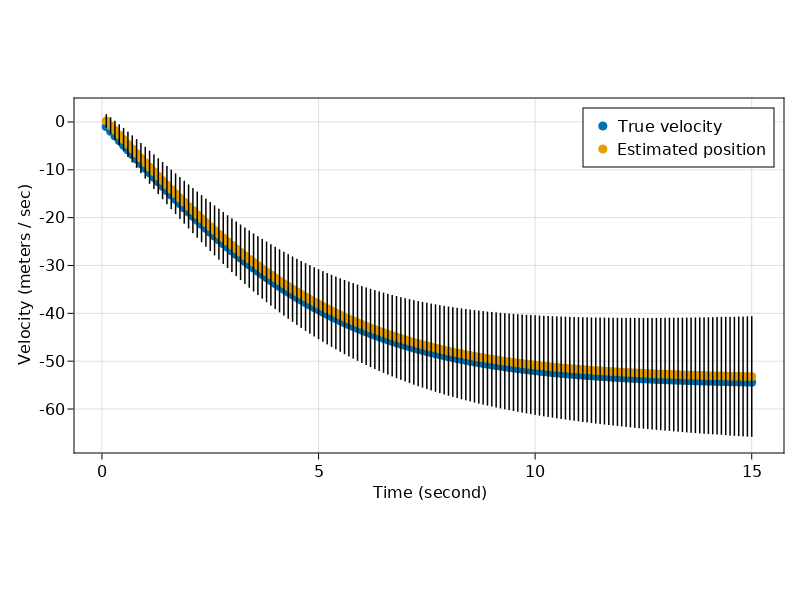

In [48]:
true_velocities_m__s = [tr_st[2] for tr_st in true_state_fcn_time]
esti_velocities_m__s = [s.state[2] for s in states_fcn_time]

scatter(
    time_axis_s,
    true_velocities_m__s,
    axis = (aspect = 2, xlabel = "Time (second)", ylabel = "Velocity (meters / sec)"),
    label="True velocity"
)

lines!(
    time_axis_s, 
    true_velocities_m__s
)

scatter!(
    time_axis_s,
    esti_velocities_m__s,
    label="Estimated position"
)

lines!(
    time_axis_s, 
    esti_velocities_m__s
)

errorbars!(
    time_axis_s,
    esti_velocities_m__s,
    [sqrt(s.cov[2, 2]) for s in states_fcn_time]
)


axislegend()
current_figure()